In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
# ---- load data saved from Julia ----
M = np.loadtxt("Data/M.csv", delimiter=",", dtype=int)
X = np.loadtxt("Data/X.csv", delimiter=",")
Y = np.loadtxt("Data/Y.csv", delimiter=",")

# Make sure shapes are as expected
print("M shape:", M.shape)
print("X range:", X.min(), X.max())
print("Y range:", Y.min(), Y.max())


M shape: (150, 150)
X range: -3.0 3.0
Y range: -3.0 3.0


In [3]:
# ---- discrete colormap for classes 0–5 ----
# 0 = unclassified / other
# 1 = periodic
# 2 = fixed point
# 3 = blow-up / integration failure
# 4 = quasi-periodic
# 5 = chaotic / irregular

colors = [
    "#f0f0f0",  # 0: unclassified - light grey
    "#6a3d9a",  # 1: periodic - purple
    "#ff7f00",  # 2: fixed point - orange
    "#b2df8a",  # 3: blow-up - light green
    "#1f78b4",  # 4: quasi-periodic - blue
    "#e31a1c",  # 5: chaotic / irregular - red
]


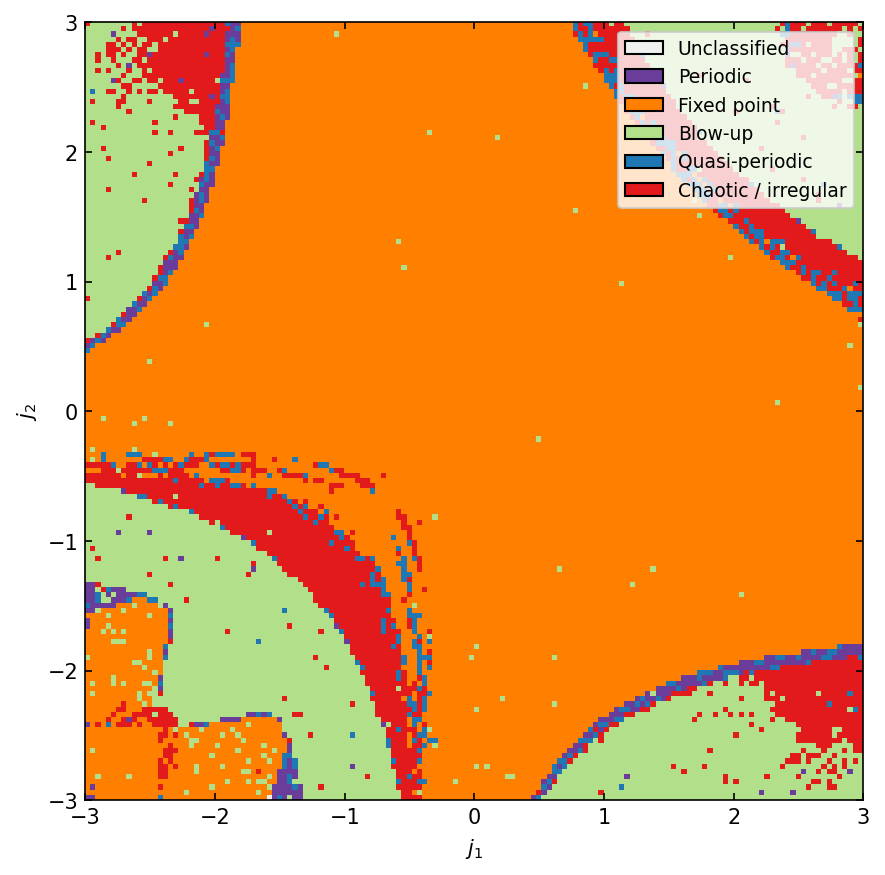

In [4]:
cmap = mpl.colors.ListedColormap(colors)
bounds = np.arange(-0.5, 6.5, 1.0)  # boundaries between 0,1,...,5
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# ---- plotting ----
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

im = ax.imshow(
    M,
    origin="lower",
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    cmap=cmap,
    norm=norm,
    aspect="equal",
    interpolation="nearest",
)

ax.set_xlabel(r"$j_1$")
ax.set_ylabel(r"$j_2$")

# ---- legend with semantic labels ----
legend_elements = [
    Patch(facecolor="#f0f0f0", edgecolor="k", label="Unclassified"),
    Patch(facecolor="#6a3d9a", edgecolor="k", label="Periodic"),
    Patch(facecolor="#ff7f00", edgecolor="k", label="Fixed point"),
    Patch(facecolor="#b2df8a", edgecolor="k", label="Blow-up"),
    Patch(facecolor="#1f78b4", edgecolor="k", label="Quasi-periodic"),
    Patch(facecolor="#e31a1c", edgecolor="k", label="Chaotic / irregular"),
]

ax.legend(
    handles=legend_elements,
    loc="upper right",
    frameon=True,
    fontsize=9,
)

# Optional: prettier ticks/fonts
ax.tick_params(direction="in", top=True, right=True)
mpl.rcParams["font.size"] = 11

fig.tight_layout()
fig.savefig("Plots/parameter_diagram_matplotlib.png", dpi=300, bbox_inches="tight")
fig.savefig("Plots/parameter_diagram_matplotlib.pdf", bbox_inches="tight")

plt.show()


In [5]:
# ---------- load data ----------
M = np.loadtxt("Data/M_LLE.csv", delimiter=",")
X = np.loadtxt("Data/X_LLE.csv", delimiter=",")
Y = np.loadtxt("Data/Y_LLE.csv", delimiter=",")

# mask NaNs (unbound regions)
M_masked = np.ma.masked_invalid(M)

finite_vals = M_masked.compressed()
if finite_vals.size > 0:
    max_abs = np.max(np.abs(finite_vals))
else:
    max_abs = 1e-1

vmax = max_abs
vmin = -max_abs

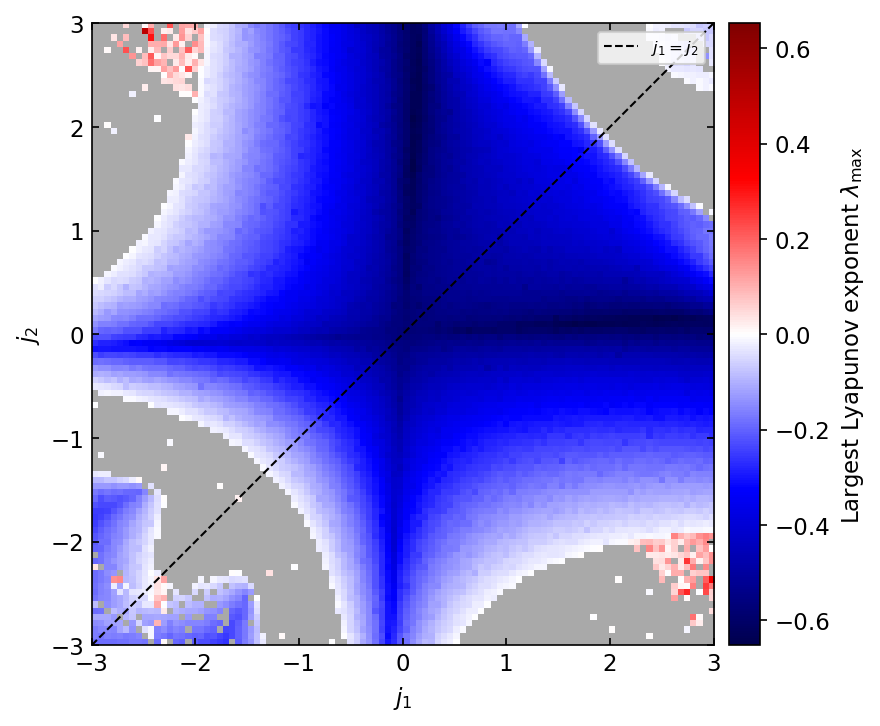

In [6]:
# ---------- plotting ----------
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

# diverging colormap centered at 0
cmap = plt.get_cmap("seismic").copy()
cmap.set_bad(color="darkgrey")  # NaNs (unbound) shown as light grey

im = ax.imshow(
    M_masked,
    origin="lower",
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    aspect="equal",
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    interpolation="nearest",
)

ax.set_xlabel(r"$j_1$")
ax.set_ylabel(r"$j_2$")

# Create a perfectly aligned colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r"Largest Lyapunov exponent $\lambda_{\max}$")

# diagonal line j1 = j2
ax.plot(X, X, color="black", linestyle="--", linewidth=1, label=r"$j_1=j_2$")

# overlay periodic-ish points if files exist
try:
    px = np.loadtxt("periodic_px.csv", delimiter=",")
    py = np.loadtxt("periodic_py.csv", delimiter=",")
    if px.ndim == 0:  # single value edge case
        px = np.array([px])
        py = np.array([py])
    ax.scatter(
        px, py,
        s=10,
        color="orange",
        edgecolors="k",
        linewidths=0.3,
        label=r"$|\lambda_{\max}| < 10^{-3}$",
    )
except OSError:
    pass  # no periodic points file; just skip

ax.legend(loc="upper right", frameon=True, fontsize=8)
ax.tick_params(direction="in", top=True, right=True)
mpl.rcParams["font.size"] = 11

fig.tight_layout()
fig.savefig("Plots/lyapunov_map.png", dpi=300, bbox_inches="tight")
fig.savefig("Plots/lyapunov_map.pdf", bbox_inches="tight")

plt.show()
